In [1]:
# Hello!
# So I want to look at crop diversity against the factor scores
# And livestock diversity
# And break this down by market orientation

# Confirms use of PAF and PCA largely equivalent, but PCA is easier for interpretation
# regression coefficients are larger because loadings are larger so scores are larger (see scales)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.stats import pearsonr
import statsmodels.api as sm

In [3]:
indicators = pd.read_csv("3PCAonImputedValues_output",encoding = "ISO-8859-1")
analysis = None
possible_analyses = ["PCA","PAF"]
analysis = input("PCA or PAF? ")
while (analysis in possible_analyses) == False:
    analysis = input("You have to choose PCA or PAF.\n PCA or PAF? ")

PCA or PAF? PCA


In [4]:
if analysis == 'PCA':
    indicators['Food Security Factor']=indicators['Food Security PCA']
    indicators['Diet Quality Factor']=indicators['Diet Quality PCA']
    indicators['Money Factor']=indicators['Money PCA']
else:
    indicators['Food Security Factor']=indicators['Food Security PAF']
    indicators['Diet Quality Factor']=indicators['Diet Quality PAF']
    indicators['Money Factor']=indicators['Money PAF']

In [5]:
# Check how correlated the factors are with each other
indicators[['Food Security Factor','Diet Quality Factor','Money Factor']].corr()
# seems reasonable

,Food Security Factor,Diet Quality Factor,Money Factor
Food Security Factor,1.000000,0.204394,0.260213
Diet Quality Factor,0.204394,1.000000,0.259350
Money Factor,0.260213,0.259350,1.000000


In [6]:
# indicators.info()

In [7]:
# Check the distribution of the households with food insecurity missing
indicators[['Country', 'FI missing', 'HHid']].groupby(['Country', 'FI missing']).count()

HHid
Country              FI missing      
Burkina Faso         0            688
                     1            256
Cambodia             1            407
DRC                  0            521
Ethiopia             0            349
India_Bihar_Vaishali 0            101
Kenya                0            636
LaoPDR               1            238
Mali                 0            236
                     1            149
Tanzania             0            972
Vietnam              1            186
Zambia               0            261

In [8]:
# only Burkina Faso and Mali have some FI there and some missing, the others are split entirely by country
# suggests that this is a slightly dodgy measure...

In [9]:
# Get ready to group by village
indicators['Coun Reg Vill']=indicators['Country']+indicators['Region']+indicators['Village'].astype(str)
indicators.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,HHid,Country,Region,Village,Latitude,Longitude,HHsizemembers,...,Food Security PCA,Diet Quality PCA,Money PCA,Diet Quality PAF,Food Security PAF,Money PAF,Food Security Factor,Diet Quality Factor,Money Factor,Coun Reg Vill
0,0,0,0,1,Kenya,Wote,175.0,-1.82,37.70,3,...,-1.265634,-0.049092,-0.917849,-0.041916,-0.813214,0.168145,-1.265634,-0.049092,-0.917849,KenyaWote175.0
1,1,1,1,2,Kenya,Wote,175.0,-1.82,37.70,10,...,-2.638708,0.017527,-1.584375,-0.079375,-1.644894,-0.845066,-2.638708,0.017527,-1.584375,KenyaWote175.0
2,2,2,2,3,Kenya,Wote,175.0,-1.82,37.71,1,...,-0.306668,1.091721,1.542909,0.801053,-0.252636,0.370787,-0.306668,1.091721,1.542909,KenyaWote175.0
3,3,3,3,4,Kenya,Wote,175.0,-1.82,37.70,4,...,-1.396385,-0.049092,-0.345198,-0.041916,-0.831591,0.235692,-1.396385,-0.049092,-0.345198,KenyaWote175.0
4,4,4,4,6,Kenya,Wote,175.0,-1.82,37.70,4,...,0.521548,0.017527,0.087812,-0.079375,0.289567,-0.034498,0.521548,0.017527,0.087812,KenyaWote175.0


In [10]:
def ols_params(x,y):
    testmod = sm.OLS(y,sm.add_constant(x))
    tes = testmod.fit()
    a = tes.params[1]
    s = tes.bse[1]
    rsq = tes.rsquared
    return (a,s, rsq)
#ols_params(indic['CropDiv'], indic['Diet Quality Factor'])

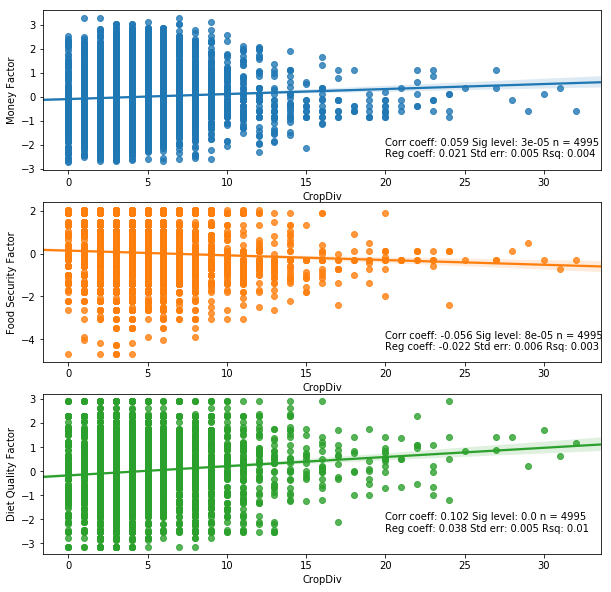

In [11]:
# Look at crop and livestock diversity against the factors.
# first, crop diversity by household;
# the correlation coefficients are not very big,
# but this does appear to vary by country.

# get rid of the small number of missing values
indic=indicators[indicators['CropDiv']<10000]
indil=indicators[indicators['LivestockDiv']<10000]

fig = plt.figure(figsize = (10,10))
ax = fig.subplots(3)
corrs = ['CropDiv','Money Factor','Food Security Factor','Diet Quality Factor']
sns.regplot('CropDiv', 'Money Factor', data=indicators, ax=ax[0])
#sns.lmplot('CropDiv', 'Money Factor', data=indicators, hue = 'Country')
sns.regplot('CropDiv', 'Food Security Factor', data=indicators, ax=ax[1])
#sns.lmplot('CropDiv', 'Food Security Factor', data=indicators, hue = 'Country')
sns.regplot('CropDiv', 'Diet Quality Factor', data=indicators, ax=ax[2])
#sns.lmplot('CropDiv', 'Diet Quality Factor', data=indicators, hue = 'Country')
if analysis == "PAF":
    fig.savefig('4 PAF 01 Crop diversity against factor scores by household')
else:
    fig.savefig('4 PCA 01 Crop diversity against factor scores by household')
for i in range (3):
    r=pearsonr(indic[corrs[0]],indic[corrs[1+i]])
    (a,s, Rsq)=ols_params(indic['CropDiv'], indic[corrs[1+i]])
    ax[i].text(20,-2.5-i*(2-i)*2, 'Corr coeff: '+str(round(r[0],3))+' Sig level: '+str(round(r[1],5))+' n = '+str(len(indic))+
              '\nReg coeff: '+str(round(a,3))+' Std err: '+str(round(s,3))+' Rsq: '+str(round(Rsq,3)))


In [12]:
data = np.array([[1,1],[2,6],[3,8],[7,30],[2,5]])
df = pd.DataFrame(data, columns = ['Independent', 'Dependent'])
df

,Independent,Dependent
0,1,1
1,2,6
2,3,8
3,7,30
4,2,5


In [13]:
testmod = sm.OLS(df['Dependent'],sm.add_constant(df['Independent']) )

tes = testmod.fit()

print(tes.summary())

                            OLS Regression Results                            
Dep. Variable:              Dependent   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     279.2
Date:                Thu, 31 Jan 2019   Prob (F-statistic):           0.000467
Time:                        09:09:10   Log-Likelihood:                -7.3740
No. Observations:                   5   AIC:                             18.75
Df Residuals:                       3   BIC:                             17.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.5909      1.065     -4.309      

C:\Users\Clare\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


In [14]:
tes.rsquared

0.98937089526443134

In [15]:
tes.bse

const          1.065422
Independent    0.291051
dtype: float64

In [16]:
first_grouping_c = indic[['CropDiv','Food Security Factor',
       'Diet Quality Factor', 'Money Factor', 'Coun Reg Vill']].groupby('Coun Reg Vill').mean()
first_grouping_l = indil[['LivestockDiv','Food Security Factor',
       'Diet Quality Factor', 'Money Factor', 'Coun Reg Vill']].groupby('Coun Reg Vill').mean()

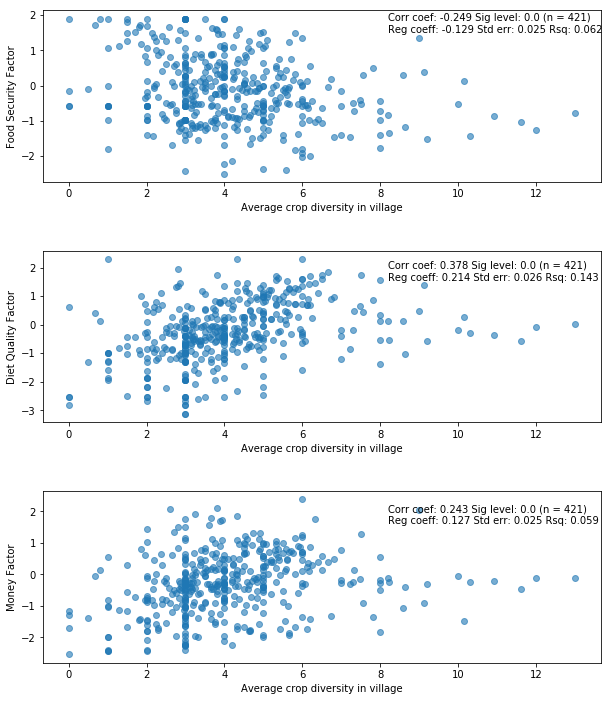

In [17]:
# Repeat the scatter graphs by village, not by household
# The correlation coefficients are now much larger, and the shapes can be seen on the scatter graphs
fig = plt.figure(figsize = (10,12))
axes = fig.subplots(3, gridspec_kw={'hspace':.4})
for i in range(3):
    axes[i].scatter(x=first_grouping_c['CropDiv'], y=first_grouping_c[first_grouping_c.columns[1+i]], alpha = .6)
    axes[i].set_ylabel(str(first_grouping_c.columns[1+i]))
    axes[i].set_xlabel('Average crop diversity in village')
    rp = pearsonr(first_grouping_c['CropDiv'], first_grouping_c[first_grouping_c.columns[1+i]])
    r = round(rp[0], 3)
    p=round(rp[1],5)
    (a, s, Rsq) = ols_params(first_grouping_c['CropDiv'], first_grouping_c[first_grouping_c.columns[1+i]])
    axes[i].text(8.2,1.5+0.05*i,'Corr coef: '+str(r)+' Sig level: '+str(p)+
                 ' (n = '+str(len(first_grouping_c))+')'+
              '\nReg coeff: '+str(round(a,3))+' Std err: '+str(round(s,3))+' Rsq: '+str(round(Rsq,3)))
if analysis=='PCA':
    fig.savefig('4 PCA 02 Crop diversity against factor scores by village')
else:
    fig.savefig('4 PAF 02 Crop diversity against factor scores by village')

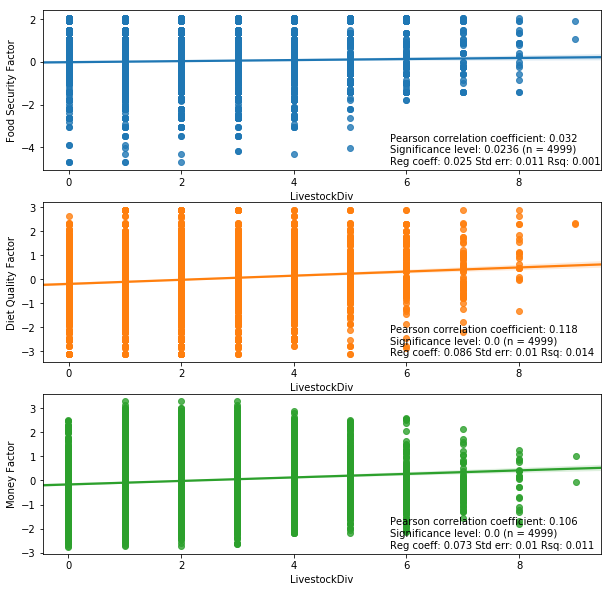

In [18]:
# for livestock diversity, all households
# again, the coefficients are small but significant
fig = plt.figure(figsize = (10,10))
ax = fig.subplots(3)
factors=['Food Security Factor','Diet Quality Factor','Money Factor']
for i in range(3):
    plot = sns.regplot('LivestockDiv', factors[i], data=indil, ax=ax[i])
    rp = pearsonr(indil['LivestockDiv'], indil[factors[i]])
    r = round(rp[0], 3)
    p=round(rp[1],5)
    (a, s, Rsq) = ols_params(indil['LivestockDiv'], indil[factors[i]])
    plot.text(5.7,-2.8-0.2*(2-i)*(2-i)*(2-i)-0.2*(2-i),'Pearson correlation coefficient: '+str(r)+'\nSignificance level: '+str(p)+
                 ' (n = '+str(len(indil))+')'+
              '\nReg coeff: '+str(round(a,3))+' Std err: '+str(round(s,3))+' Rsq: '+str(round(Rsq,3)))
if analysis=='PCA':    
    fig.savefig('4 PCA 03 Livestock diversity against factor scores by household')
else:
    fig.savefig('4 PAF 03 Livestock diversity against factor scores by household')

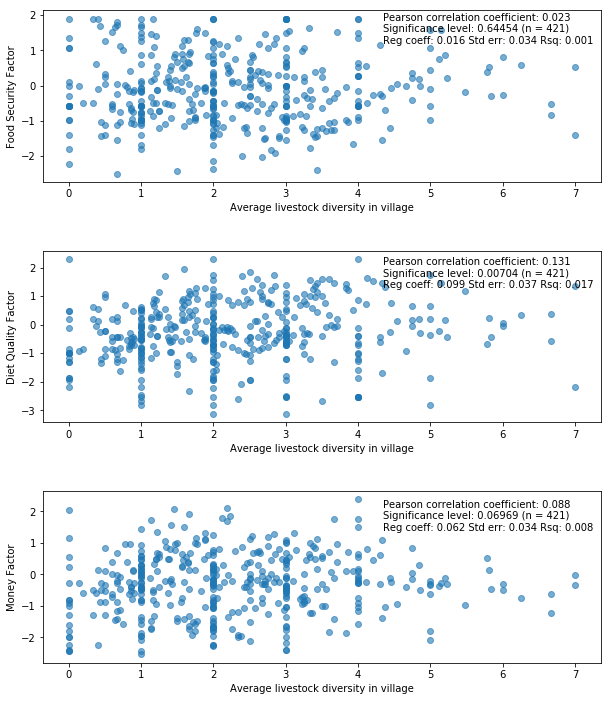

In [19]:
# this time the correlation coefficients are small even at the village level

fig = plt.figure(figsize = (10,12))
axes = fig.subplots(3, gridspec_kw={'hspace':.4})
for i in range(3):
    axes[i].scatter(x=first_grouping_l['LivestockDiv'], y=first_grouping_l[first_grouping_l.columns[1+i]], alpha = .6)
    axes[i].set_ylabel(str(first_grouping_l.columns[1+i]))
    axes[i].set_xlabel('Average livestock diversity in village')
    rp = pearsonr(first_grouping_l['LivestockDiv'], first_grouping_l[first_grouping_l.columns[1+i]])
    r = round(rp[0], 3)
    p=round(rp[1],5)
    (a, s, Rsq) = ols_params(first_grouping_l['LivestockDiv'], first_grouping_l[first_grouping_l.columns[1+i]])
    axes[i].text(4.35,1.19+0.1*i,'Pearson correlation coefficient: '+str(r)+'\nSignificance level: '+str(p)+
                 ' (n = '+str(len(first_grouping_l))+')'+
              '\nReg coeff: '+str(round(a,3))+' Std err: '+str(round(s,3))+' Rsq: '+str(round(Rsq,3)))
if analysis=='PAF':
    fig.savefig('4 PAF 04 Livestock diversity against factor scores by village')
else:
    fig.savefig('4 PCA 04 Livestock diversity against factor scores by village')

In [20]:
len(indicators['Country'].unique())

11

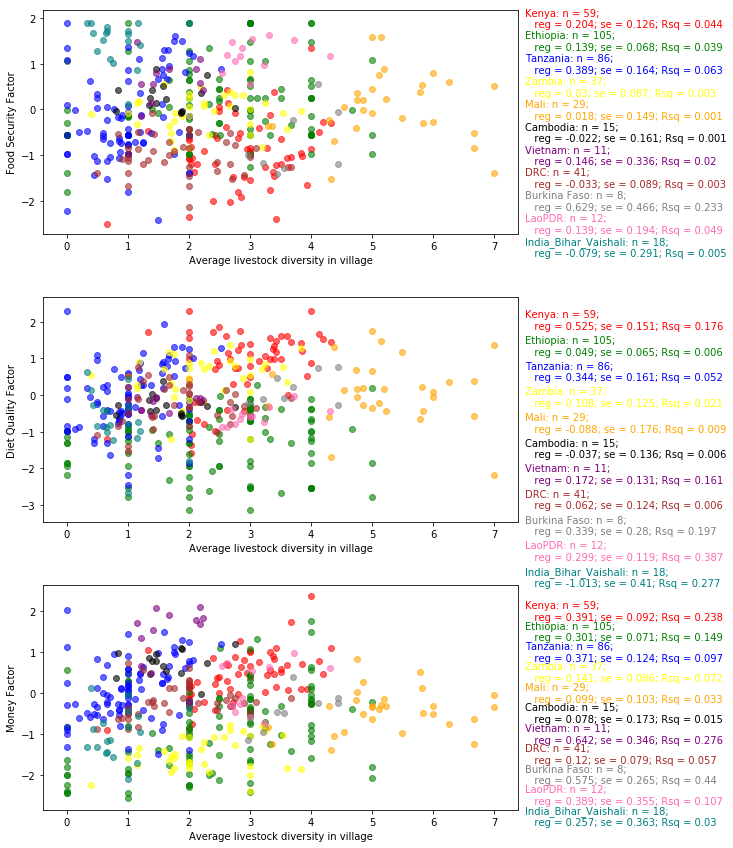

In [21]:
fig = plt.figure(figsize = (12,12))
#axes = fig.subplots(3, gridspec_kw={'hspace':.4, 'wspace':2})
colours = ('red','green','blue','yellow','orange','black','purple','brown','grey','hotpink','teal')
for i in range(3):
    axes[i]=fig.add_axes([.07,0.667-0.333*i+.05,.55,0.26])
    for j in range(11):
        subset = indil[indil['Country']==indil['Country'].unique()[j]]
        grouping = subset[['CropDiv', 'LivestockDiv','Food Security Factor',
                               'Diet Quality Factor', 'Money Factor', 'Coun Reg Vill']].groupby('Coun Reg Vill').mean()
        axes[i].scatter(x=grouping['LivestockDiv'], y=grouping[grouping.columns[2+i]], alpha = .6, color=colours[j])
        axes[i].set_ylabel(str(grouping.columns[2+i]))
        axes[i].set_xlabel('Average livestock diversity in village')
        rp = pearsonr(grouping['LivestockDiv'], grouping[grouping.columns[2+i]])
        r = round(rp[0], 3)
        p = round(rp[1],5)
        n = len(grouping)
        (a, s, Rsq) = ols_params(grouping['LivestockDiv'], grouping[grouping.columns[2+i]])
#        axes[i].text(7.5, 1.8+0.2*i-0.5*j*(10+i+i*(2-i))*0.1+0.1*i*(2-i), indicators['Country'].unique()[j]+'; r = '+str(r)+'; p = '+
#                     str(p)+'; n = '+str(n)+';\n   reg = '+str(round(a,3))+'; se = '+str(round(s,3))+
 #                    '; Rsq = '+str(round(Rsq,3)), color=colours[j])
        axes[i].text(7.5, 1.8+0.2*i-0.2*i*(2-i)*j-0.5*j, indicators['Country'].unique()[j]+': n = '+str(n)+';\n   reg = '+str(round(a,3))+'; se = '+str(round(s,3))+
                     '; Rsq = '+str(round(Rsq,3)), color=colours[j])
if analysis=='PCA':
    fig.savefig('4 PCA 05 Livestock diversity against factor scores by village by country')
else:
    fig.savefig('4 PAF 05 Livestock diversity against factor scores by village by country')



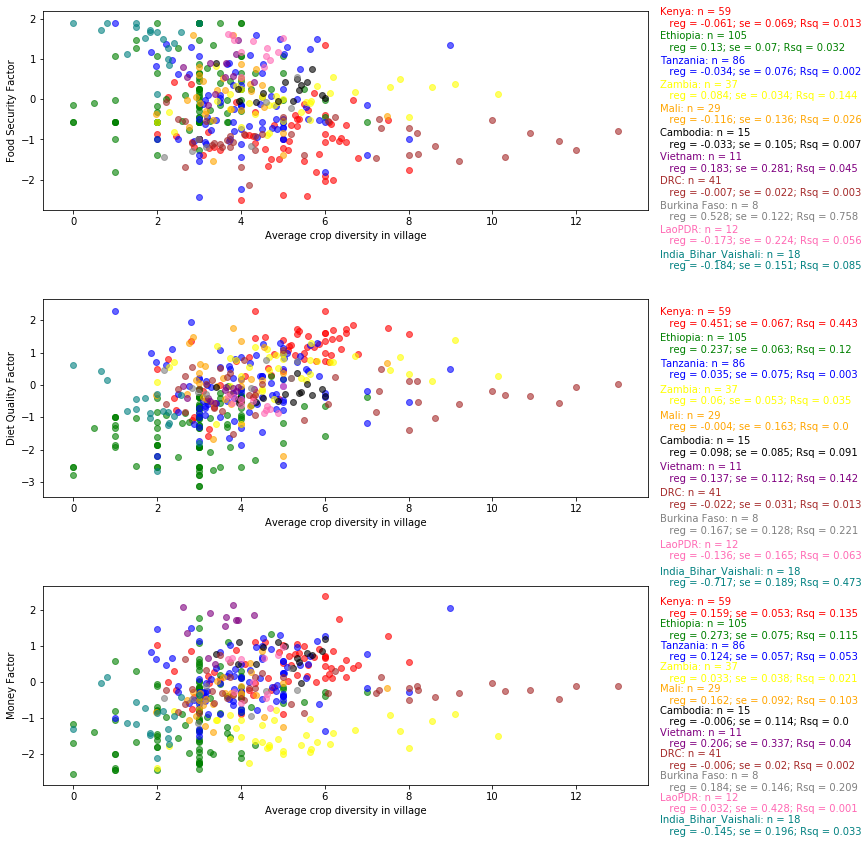

In [22]:
fig = plt.figure(figsize = (14,12))
#axes = fig.subplots(3, gridspec_kw={'hspace':.4})
colours = ('red','green','blue','yellow','orange','black','purple','brown','grey','hotpink','teal')
for i in range(3):
    axes[i]=fig.add_axes([.07,0.72-0.333*i+.05,.6,0.23])
    for j in range(11):
        subset = indic[indic['Country']==indic['Country'].unique()[j]]
        grouping = subset[['CropDiv', 'LivestockDiv','Food Security Factor',
                               'Diet Quality Factor', 'Money Factor', 'Coun Reg Vill']].groupby('Coun Reg Vill').mean()
        axes[i].scatter(x=grouping['CropDiv'], y=grouping[grouping.columns[2+i]], alpha = .6, color=colours[j])
        axes[i].set_ylabel(str(grouping.columns[2+i]))
        axes[i].set_xlabel('Average crop diversity in village')
        rp = pearsonr(grouping['CropDiv'], grouping[grouping.columns[2+i]])
        r = round(rp[0], 3)
        p = round(rp[1],5)
        n = len(grouping)
        (a,s,Rsq)=ols_params(grouping['CropDiv'], grouping[grouping.columns[2+i]])
#        axes[i].text(14, 1.8+0.2*i-0.6*j*(10+i+i*(2-i))*0.1+0.1*i*(2-i), indicators['Country'].unique()[j]+'; r = '+str(r)+'; p = '+
 #                    str(p)+' (n = '+str(n)+')\n   reg = '+str(round(a,3))+'; se = '+str(round(s,3))+
  #                   '; Rsq = '+str(round(Rsq,3)), color=colours[j])
        axes[i].text(14, 1.8+0.2*i-0.2*i*(2-i)*j-0.6*j, indicators['Country'].unique()[j]+': n = '+str(n)+'\n   reg = '+str(round(a,3))+'; se = '+str(round(s,3))+
                     '; Rsq = '+str(round(Rsq,3)), color=colours[j])

if analysis == "PCA":
    fig.savefig('4 PCA 06 Crop diversity against factor scores by village by country')
else:
    fig.savefig('4 PAF 06 Crop diversity against factor scores by village by country')

In [23]:
# next, I want to split it up by market orientation
# I had 4 market orientation quartiles before.
prepc=indic[indic['FAMarketOrientation']<1.1]
prepl=indil[indil['FAMarketOrientation']<1.1]

second_grouping_c = prepc[['CropDiv', 'LivestockDiv','Food Security Factor',
       'Diet Quality Factor', 'Money Factor', 'Coun Reg Vill', 'FAMarketOrientation']].groupby('Coun Reg Vill').mean()
second_grouping_l = prepl[['CropDiv', 'LivestockDiv','Food Security Factor',
       'Diet Quality Factor', 'Money Factor', 'Coun Reg Vill', 'FAMarketOrientation']].groupby('Coun Reg Vill').mean()

In [24]:
second_grouping_c['MAQuartile']=0
for j in range(4):
 #   print(second_grouping[['FAMarketOrientation','MAQuartile']][11:20])
    q = second_grouping_c['FAMarketOrientation'].quantile(0.25*(j+1))
  #  print(q)
    second_grouping_c['MAQuartile']=np.where(second_grouping_c['FAMarketOrientation']>q, second_grouping_c['MAQuartile']+1, second_grouping_c['MAQuartile'])
    
second_grouping_l['MAQuartile']=0
for j in range(4):
 #   print(second_grouping[['FAMarketOrientation','MAQuartile']][11:20])
    q = second_grouping_l['FAMarketOrientation'].quantile(0.25*(j+1))
  #  print(q)
    second_grouping_l['MAQuartile']=np.where(second_grouping_l['FAMarketOrientation']>q, second_grouping_l['MAQuartile']+1, second_grouping_l['MAQuartile'])

In [25]:
second_grouping_l.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, Burkina FasoBANI2.0 to ZambiaPetauke99.0
Data columns (total 7 columns):
CropDiv                 418 non-null float64
LivestockDiv            418 non-null float64
Food Security Factor    418 non-null float64
Diet Quality Factor     418 non-null float64
Money Factor            418 non-null float64
FAMarketOrientation     418 non-null float64
MAQuartile              418 non-null int64
dtypes: float64(6), int64(1)
memory usage: 26.1+ KB


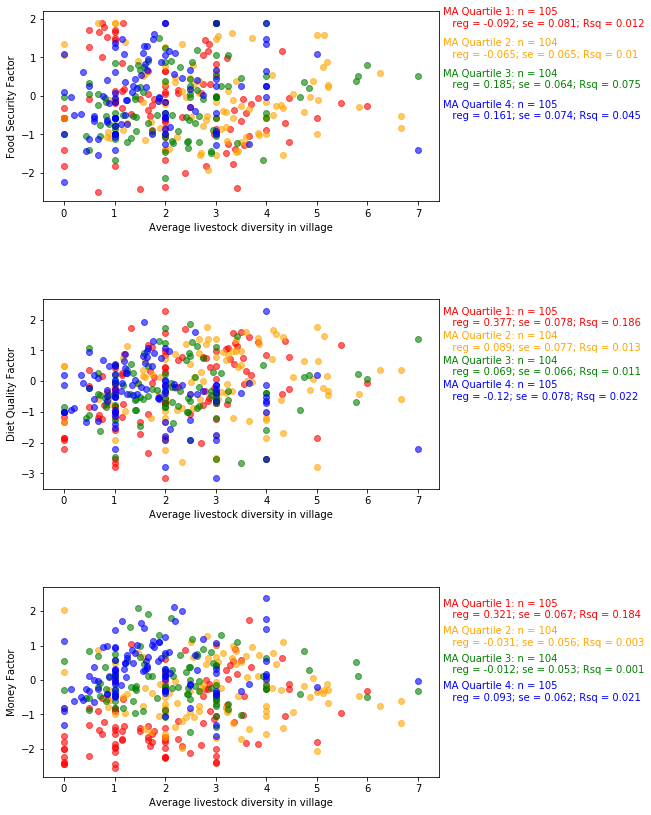

In [26]:
fig = plt.figure(figsize = (10,12))
#axes = fig.subplots(3, gridspec_kw={'hspace':.4})
colours = ('red','orange','green','blue')
for i in range(3):
    axes[i]=fig.add_axes([.07,0.667-0.333*i+.05,.55,0.22])
    for j in range(4):
        grouping = second_grouping_l[second_grouping_l['MAQuartile']==j]
        axes[i].scatter(x=grouping['LivestockDiv'], y=grouping[grouping.columns[2+i]], alpha = .6, color=colours[j])
        axes[i].set_ylabel(str(grouping.columns[2+i]))
        axes[i].set_xlabel('Average livestock diversity in village')
        rp = pearsonr(grouping['LivestockDiv'], grouping[grouping.columns[2+i]])
        r = round(rp[0],3)
        p = round(rp[1],5)
        n = len(grouping)
        (a, s, Rsq ) = ols_params(grouping['LivestockDiv'], grouping[grouping.columns[2+i]])
#        axes[i].text(7.5, 1.8-0.8*j, 'MA Quartile '+str(j+1)+'; r = '+str(r)+'; p = '+str(p)+' (n = '+str(n)+')\n   reg = '
 #                    +str(round(a,3))+'; se = '+str(round(s,3))+
  #                   '; Rsq = '+str(round(Rsq,3)), color=colours[j])
        axes[i].text(7.5, 1.8-0.8*j, 'MA Quartile '+str(j+1)+': n = '+str(n)+'\n   reg = '
                     +str(round(a,3))+'; se = '+str(round(s,3))+
                     '; Rsq = '+str(round(Rsq,3)), color=colours[j])
if analysis =='PAF':
    fig.savefig('4 PAF 07 Livestock diversity against factor scores by village by MA quartile')
else:
    fig.savefig('4 PCA 07 Livestock diversity against factor scores by village by MA quartile')

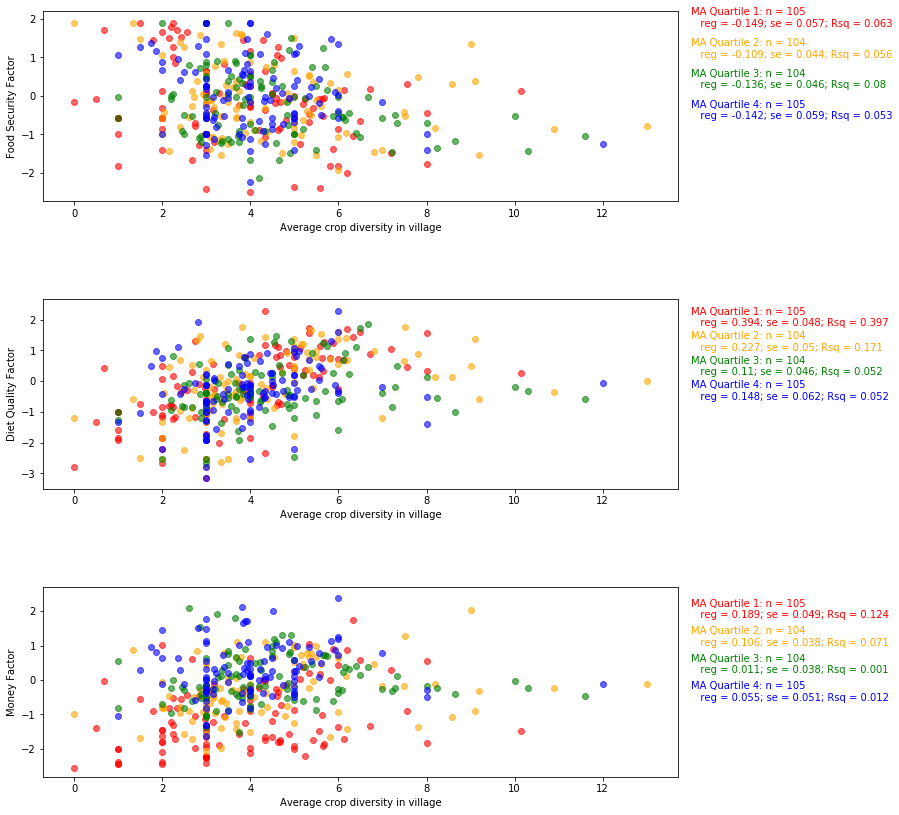

In [27]:
fig = plt.figure(figsize = (14,12))
#axes = fig.subplots(3, gridspec_kw={'hspace':.4})
colours = ('red','orange','green','blue')
for i in range(3):
    axes[i]=fig.add_axes([.07,0.667-0.333*i+.05,.63,0.22])
    for j in range(4):
        grouping = second_grouping_c[second_grouping_c['MAQuartile']==j]
        axes[i].scatter(x=grouping['CropDiv'], y=grouping[grouping.columns[2+i]], alpha = .6, color=colours[j])
        axes[i].set_ylabel(str(grouping.columns[2+i]))
        axes[i].set_xlabel('Average crop diversity in village')
        rp = pearsonr(grouping['CropDiv'], grouping[grouping.columns[2+i]])
        r = round(rp[0], 3)
        p = round(rp[1],5)
        n = len(grouping)
        (a,s,Rsq) = ols_params(grouping['CropDiv'], grouping[grouping.columns[2+i]])
#        axes[i].text(14, 1.8-0.8*j, 'MA Quartile '+str(j+1)+'; r = '+str(r)+'; p = '+str(p)+' (n = '+str(n)+')\n   reg = '
 #                    +str(round(a,3))+'; se = '+str(round(s,3))+
  #                   '; Rsq = '+str(round(Rsq,3)), color=colours[j])
        axes[i].text(14, 1.8-0.8*j, 'MA Quartile '+str(j+1)+': n = '+str(n)+'\n   reg = '
                     +str(round(a,3))+'; se = '+str(round(s,3))+
                     '; Rsq = '+str(round(Rsq,3)), color=colours[j])
if analysis == 'PCA':
    fig.savefig('4 PCA 08 Crop diversity against factor scores by village by MA quartile')
else:
    fig.savefig('4 PAF 08 Crop diversity against factor scores by village by MA quartile')

In [28]:
prepc['MAQuartile']=0
for j in range(4):
 #   print(second_grouping[['FAMarketOrientation','MAQuartile']][11:20])
    q = prepc['FAMarketOrientation'].quantile(0.25*(j+1))
  #  print(q)
    prepc['MAQuartile']=np.where(prepc['FAMarketOrientation']>q, prepc['MAQuartile']+1, prepc['MAQuartile'])
    
prepl['MAQuartile']=0
for j in range(4):
 #   print(second_grouping[['FAMarketOrientation','MAQuartile']][11:20])
    q = prepl['FAMarketOrientation'].quantile(0.25*(j+1))
  #  print(q)
    prepl['MAQuartile']=np.where(prepl['FAMarketOrientation']>q, prepl['MAQuartile']+1, prepl['MAQuartile'])

C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [29]:
factors

['Food Security Factor', 'Diet Quality Factor', 'Money Factor']

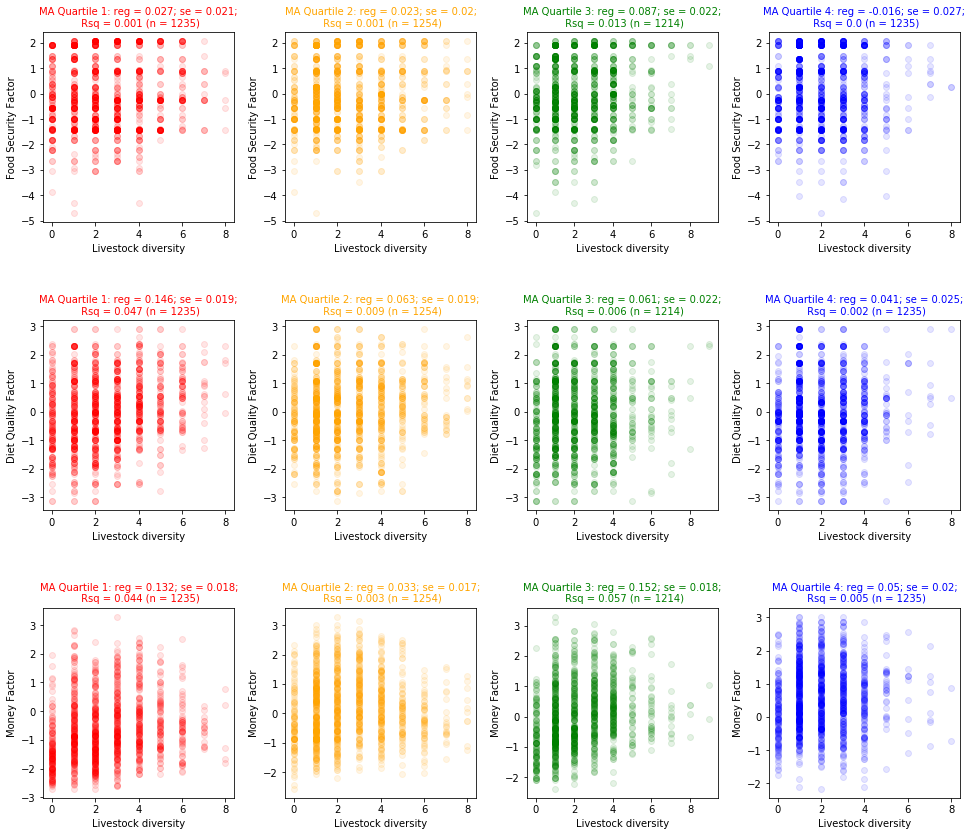

In [30]:
fig = plt.figure(figsize = (14,12))
#axes = fig.subplots(3, gridspec_kw={'hspace':.4})
colours = ('red','orange','green','blue')
for i in range(3):
    for j in range(4):
        axes=fig.add_axes([.07+0.24*j,0.667-0.333*i+.05,0.19,0.22])
        grouping = prepl[prepl['MAQuartile']==j]
        axes.scatter(x=grouping['LivestockDiv'], y=grouping[factors[i]], alpha = .1, color=colours[j])
        axes.set_ylabel(str(factors[i]))
        axes.set_xlabel('Livestock diversity')
        rp = pearsonr(grouping['LivestockDiv'], grouping[factors[i]])
        r = round(rp[0],3)
        p = round(rp[1],5)
        n = len(grouping)
        (a,s,Rsq) = ols_params(grouping['LivestockDiv'], grouping[factors[i]])
        axes.set_title('MA Quartile '+str(j+1)+': reg = '
                     +str(round(a,3))+'; se = '+str(round(s,3))+
                     ';\n Rsq = '+str(round(Rsq,3))+' (n = '+str(n)+')', color=colours[j], size=10)
if analysis == 'PCA':
    fig.savefig('4 PCA 09 Livestock diversity against factor scores by household by MA quartile')
else:
    fig.savefig('4 PAF 09 Livestock diversity against factor scores by household by MA quartile')

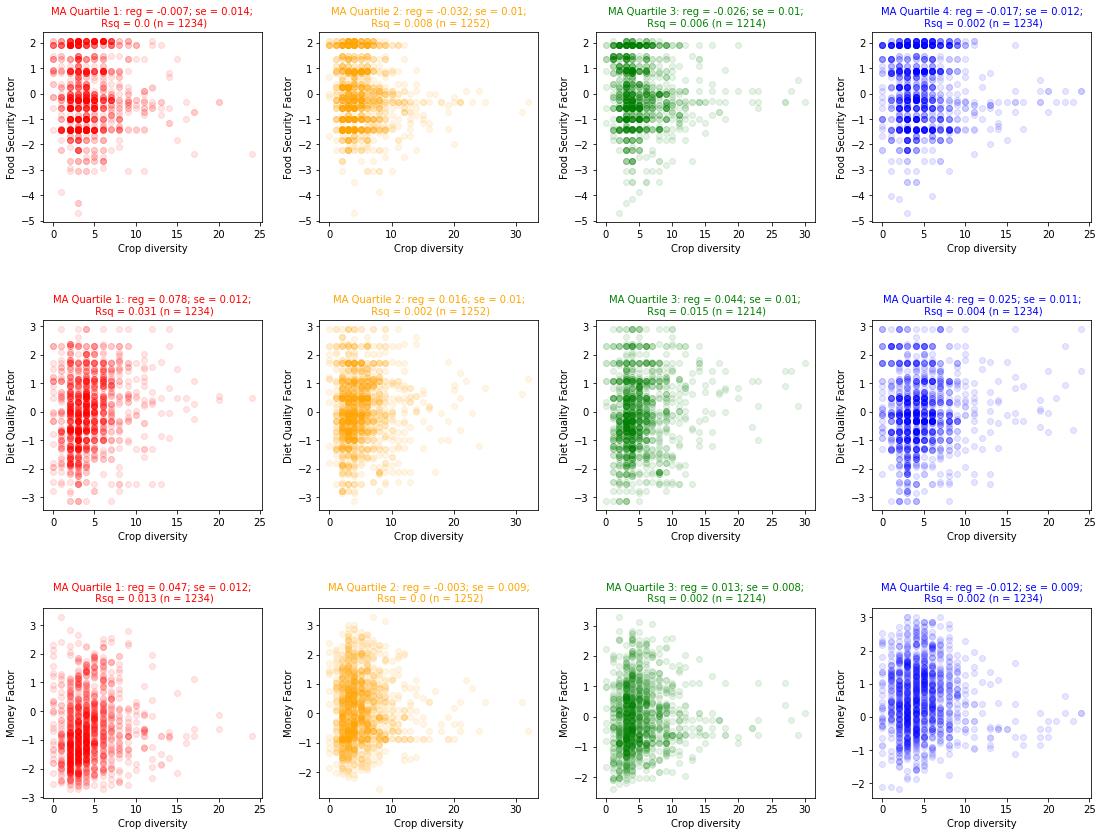

In [31]:
fig = plt.figure(figsize = (16,12))
#axes = fig.subplots(3, gridspec_kw={'hspace':.4})
colours = ('red','orange','green','blue')
for i in range(3):
    for j in range(4):
        axes=fig.add_axes([.07+0.24*j,0.667-0.333*i+.05,.19,0.22])
        grouping = prepc[prepc['MAQuartile']==j]
        axes.scatter(x=grouping['CropDiv'], y=grouping[factors[i]], alpha = .1, color=colours[j])
        axes.set_ylabel(str(factors[i]))
        axes.set_xlabel('Crop diversity')
        rp = pearsonr(grouping['CropDiv'], grouping[factors[i]])
        r = round(rp[0],3)
        p = round(rp[1],5)
        n = len(grouping)
        (a,s,Rsq)=ols_params(grouping['CropDiv'], grouping[factors[i]])
        axes.set_title('MA Quartile '+str(j+1)+': reg = '
                     +str(round(a,3))+'; se = '+str(round(s,3))+
                     ';\n Rsq = '+str(round(Rsq,3))+' (n = '+str(n)+')', color=colours[j], size=10)
if analysis == 'PCA':
    fig.savefig('4 PCA 10 Crop diversity against factor scores by household by MA quartile')
else:
    fig.savefig('4 PCA 10 Crop diversity against factor scores by household by MA quartile')

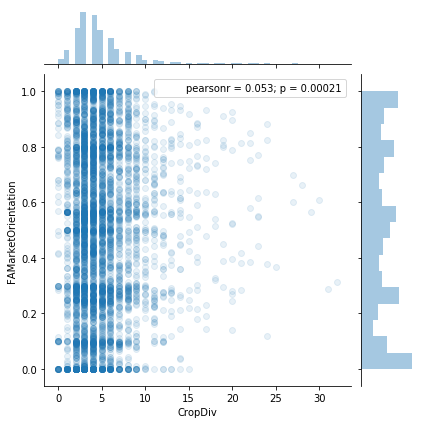

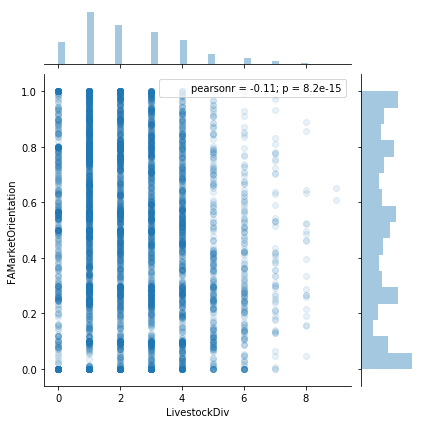

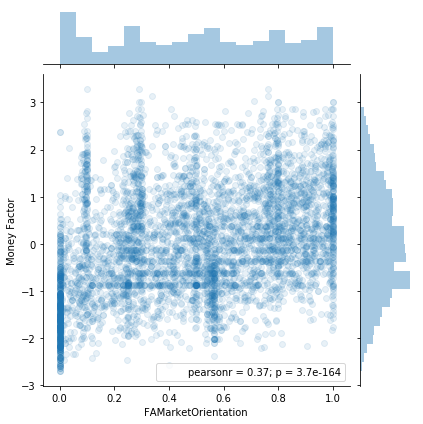

In [32]:
if analysis == 'PCA':
    sns.jointplot(x='CropDiv', y='FAMarketOrientation',data=indicators, alpha = .1).savefig('4 PCA 11 cropdiv by market orientation')
    sns.jointplot(x='LivestockDiv', y='FAMarketOrientation',data=indicators, alpha=.1).savefig('4 PCA 12 livestockdiv by market orientation')
    sns.jointplot(x='FAMarketOrientation', y='Money Factor',data=indicators, alpha=.1).savefig('4 PCA 13 market orientation by money')
else:
    sns.jointplot(x='CropDiv', y='FAMarketOrientation',data=indicators, alpha = .1).savefig('4 PAF 11 cropdiv by market orientation')
    sns.jointplot(x='LivestockDiv', y='FAMarketOrientation',data=indicators, alpha=.1).savefig('4 PAF 12 livestockdiv by market orientation')
    sns.jointplot(x='FAMarketOrientation', y='Money Factor',data=indicators, alpha=.1).savefig('4 PAF 13 market orientation by money')

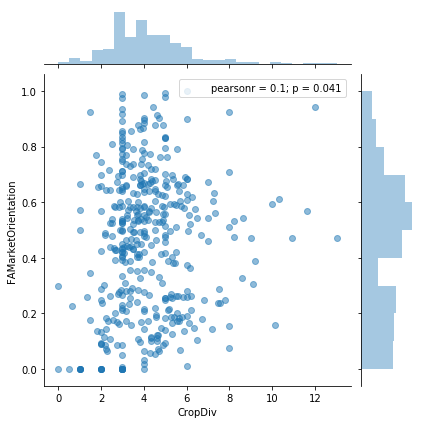

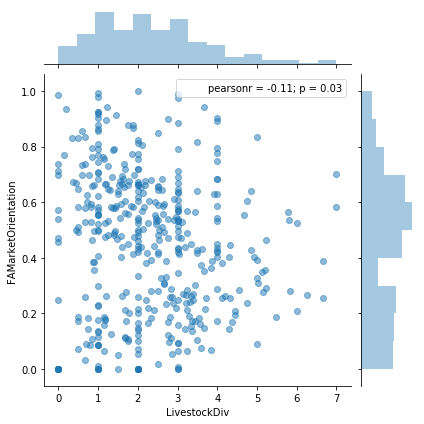

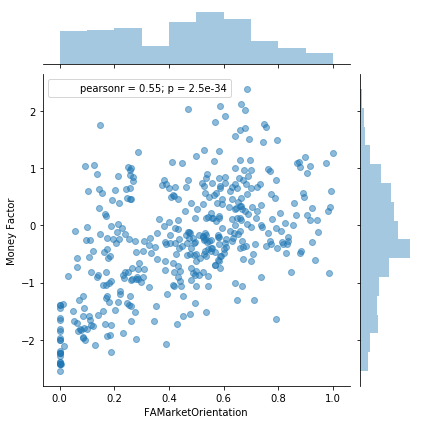

In [33]:
if analysis == 'PCA':
    sns.jointplot(x='CropDiv', y='FAMarketOrientation',data=second_grouping_c, alpha = .5).savefig('4 PCA 14 cropdiv by market orientation')
    sns.jointplot(x='LivestockDiv', y='FAMarketOrientation',data=second_grouping_l, alpha=.5).savefig('4 PCA 15 livestockdiv by market orientation')
    sns.jointplot(x='FAMarketOrientation', y='Money Factor',data=second_grouping_l, alpha=.5).savefig('4 PCA 16 market orientation by money')
else:
    sns.jointplot(x='CropDiv', y='FAMarketOrientation',data=second_grouping_c, alpha = .5).savefig('4 PCA 14 cropdiv by market orientation')
    sns.jointplot(x='LivestockDiv', y='FAMarketOrientation',data=second_grouping_l, alpha=.5).savefig('4 PCA 15 livestockdiv by market orientation')
    sns.jointplot(x='FAMarketOrientation', y='Money Factor',data=second_grouping_l, alpha=.5).savefig('4 PCA 16 market orientation by money')